In [1]:
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
from argparse import ArgumentParser
from scipy.stats import spearmanr, pearsonr

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

import pickle
import gzip
from pathlib import Path

# set seeds
from numpy.random import seed
seed(1)


In [3]:

def read_gse_input(cell_file, count_file, gene_file, meta_file, meta_tsne_file):
    cell_info = pd.read_table(cell_file, names=["cell_names"], header=None)
    cell_info["idx"] = range(1,cell_info.shape[0]+1) # we need the index for later -- 1 indexed!

    count_ptr = gzip.open(count_file, "r")
    count_matr = pd.read_table(count_ptr, skiprows=2, names=["gene_idx", "cell_idx", "expr"], sep=" ")

    gene_info = pd.read_table(gene_file, names=["gene_ids"], header=None)

    meta_info = pd.read_table(meta_file)

    # merge metadata with cell_type labels 
    meta_tsne = pd.read_table(meta_tsne_file, skiprows=[1])
    meta_tsne.rename(columns = {'NAME':'Name'}, inplace = True)
    meta_info = meta_info.merge(meta_tsne[["Name", "CellType"]], on="Name")

    return (cell_info, count_matr, gene_info, meta_info)

def format_cell_reads_info(meta_info, cell_info, count_matr, method_keep, experiment_keep, num_cells_expected):
    # first lets take a look at the data
    uniq_methods = meta_info["Method"].unique()
    print(f"Methods used: {uniq_methods}")

    uniq_expr = meta_info["Experiment"].unique()
    print(f"Experiment IDs: {uniq_expr}")

    # now lets get the names of the cells of interest
    names_keep = meta_info[(meta_info["Method"].isin(method_keep)) &
                        (meta_info["Experiment"].isin(experiment_keep))]
    names_keep = names_keep["Name"]

    if names_keep.shape[0] != num_cells_expected:
        assert False, "Incorrect number of cells from names_keep."

    # now get the indices of the cells
    cells_keep = cell_info[cell_info["cell_names"].isin(names_keep)]
    print(cells_keep.shape[0])
    print(num_cells_expected)
    if cells_keep.shape[0] != num_cells_expected:
        assert False, "Incorrect number of cells from cells_keep."

    # using this index, get the count matrix using only the cells of interest
    pbmc1_a_mm = count_matr[count_matr["cell_idx"].isin(cells_keep["idx"])]

    # now format it to the dense repr
    pbmc1_a_dense = pd.crosstab(index=pbmc1_a_mm["gene_idx"],
                                columns=pbmc1_a_mm["cell_idx"],
                                values=pbmc1_a_mm["expr"],
                                aggfunc=sum,
                                dropna=True)
    pbmc1_a_dense = pbmc1_a_dense.fillna(0)
    if pbmc1_a_dense.shape[1] != num_cells_expected:
        assert False, "Incorrect number of cells after reshaping."

    return pbmc1_a_dense


def filter_by_expr(pbmc1_a_dense, min_num_cells, gene_info):

    pbmc1_a_binary = np.where(pbmc1_a_dense>0,1,0)
    pbmc1_a_expr = pbmc1_a_dense[pbmc1_a_binary.sum(axis=1) > min_num_cells]
    print(f"Filtered table size: {pbmc1_a_expr.shape}")

    # the pbmc1_a_expr is 1-indexed
    gene_pass_idx = pbmc1_a_expr.index.to_numpy()-1

    gene_pass = gene_info.iloc[gene_pass_idx]
    return (pbmc1_a_expr, gene_pass)

def join_metadata(cell_info, meta_info, pbmc1_a_expr, gene_pass):
    cell_meta_info = cell_info.merge(meta_info, left_on=["cell_names"], right_on=["Name"])

    # first transpose
    pbmc1_a_df = pbmc1_a_expr.transpose()
    pbmc1_a_df.columns = gene_pass["gene_ids"]
    expr_col = pbmc1_a_df.columns

    # now merge
    pbmc1_a_df = cell_meta_info.merge(pbmc1_a_df, left_on=["idx"], right_on=["cell_idx"])
    col_interest = ["CellType"]
    col_interest = col_interest + expr_col.tolist()
    pbmc1_a_df = pbmc1_a_df[col_interest]

    return pbmc1_a_df, expr_col


In [4]:
aug_data_path=f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

meta_tsne_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_meta.txt"
meta_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_meta_counts_new.txt"

pbmc2_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2', 
                    "Experiment":'pbmc2', 
                    "min_num_cells":[-1], 
                    "num_cells":[3362],
                    "file_id":'pbmc_rep2_10xV2_sm2_cells'})


pbmc1_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                    "Experiment":'pbmc1', 
                    "min_num_cells":[-1], 
                    "num_cells":[253],
                    "file_id":'pbmc_rep1_sm2'})

def get_count_df(exp_id):
    if exp_id == "pbmc_rep1_sm2" :
        curr_study = pbmc1_smart_seq2_param
        gene_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_genes_read.txt"
        count_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_counts_read.txt.gz"
        cell_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_cells_read_new.txt"
    elif exp_id == "pbmc_rep2_10xV2_sm2_cells":
        curr_study = pbmc2_10x_sm2_cells_param
        gene_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_genes_umi.txt"
        count_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_counts_umi.txt.gz"
        cell_file=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/GSE132044_cells_umi_new.txt"

    else:
        assert False, "Unrecognized experiment ID"


    # set the study specific parameters
    min_num_cells = pd.to_numeric(curr_study["min_num_cells"][0])
    method_keep = curr_study["Method"].tolist()
    experiment_keep = curr_study["Experiment"].tolist()
    num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])

    ########################
    ### generate samples ###
    ########################
    # now generate the augmented samples
    cell_info, count_matr, gene_info, meta_info = read_gse_input(cell_file, 
                                                                count_file, 
                                                                gene_file, 
                                                                meta_file, 
                                                                meta_tsne_file)

    pbmc1_a_dense = format_cell_reads_info(meta_info, cell_info, count_matr, method_keep, experiment_keep, num_cells_expected)

    pbmc1_a_expr, gene_pass = filter_by_expr(pbmc1_a_dense, min_num_cells, gene_info)

    pbmc1_a_df, expr_col = join_metadata(cell_info, meta_info, pbmc1_a_expr, gene_pass)
    print(pbmc1_a_df.head)
    return pbmc1_a_df, gene_info

In [5]:
pbmc1_sm2_df, pbmc1_sm2_gene_info = get_count_df("pbmc_rep1_sm2")
pbmc2_10x_df, pbmc2_10x_gene_info = get_count_df("pbmc_rep2_10xV2_sm2_cells")

Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
253
253
Filtered table size: (22654, 253)
<bound method NDFrame.head of              CellType  ENSG00000000003_TSPAN6  ENSG00000000005_TNMD  \
0    Cytotoxic T cell                     0.0                   0.0   
1    Cytotoxic T cell                     0.0                   0.0   
2    Cytotoxic T cell                     0.0                   0.0   
3    Cytotoxic T cell                     0.0                   0.0   
4    Cytotoxic T cell                     0.0                   0.0   
..                ...                     ...                   ...   
248    CD16+ monocyte                     0.0                   0.0   
249    CD16+ monocyte                     0.0                   0.0   
250    CD16+ monocyte                     0.0                   0.0   
251    CD16+ monocyte              

In [42]:
num_cell_min = 10
pbmc1_sm2_df_all = pbmc1_sm2_df.drop("CellType", axis=1)
pbmc1_sm2_df_all = pbmc1_sm2_df_all.transpose()
pbmc1_a_binary = np.where(pbmc1_sm2_df_all>0,1,0)
pbmc1_sm2_df_all = pbmc1_sm2_df_all[pbmc1_a_binary.sum(axis=1) > num_cell_min]

pbmc2_10x_df_all = pbmc2_10x_df[pbmc2_10x_df["CellType"].isin(["Cytotoxic T cell"])]
pbmc2_10x_df_all = pbmc2_10x_df_all.drop("CellType", axis=1)
pbmc2_10x_df_all = pbmc2_10x_df_all.transpose()
pbmc1_a_binary = np.where(pbmc2_10x_df_all>0,1,0)
pbmc2_10x_df_all = pbmc2_10x_df_all[pbmc1_a_binary.sum(axis=1) > num_cell_min]

pbmc2_10x_df_all = pbmc2_10x_df_all.transpose()
pbmc1_sm2_df_all = pbmc1_sm2_df_all.transpose()

col_inter = pbmc1_sm2_df_all.columns.intersection(pbmc2_10x_df_all.columns)

pbmc1_sm2_df_all = pbmc1_sm2_df_all.reindex(columns=col_inter)
sm2_sum = pbmc1_sm2_df_all.sum(axis=0)
x10_sum = pbmc2_10x_df_all.sum(axis=0)


spr_err = pearsonr(sm2_sum.astype(float), x10_sum.astype(float))[0]
print(spr_err)

print(pbmc1_sm2_df_all.shape)
print(pbmc2_10x_df_all.shape)
pbmc1_sm2_df_all

0.5633383343405872
(253, 10041)
(694, 10041)


,ENSG00000000003_TSPAN6,ENSG00000000419_DPM1,ENSG00000000457_SCYL3,ENSG00000000938_FGR,ENSG00000001036_FUCA2,ENSG00000001084_GCLC,ENSG00000001167_NFYA,ENSG00000001461_NIPAL3,ENSG00000001497_LAS1L,ENSG00000001561_ENPP4,...,ENSG00000281548_LINC00895,ENSG00000281560_LSINCT5,ENSG00000281649_EBLN3,ENSG00000281706_LINC01012,ENSG00000281741_AC241377.2,ENSG00000282386_RP11-422P24.12,ENSG00000282851_BISPR,ENSG00000282988_RP1-34B20.21,ENSG00000283013_RP11-511P7.5,ENSG00000283103_LLNLR-245B6.1
0,0,366.0,0.0,1.0,35.0,0.0,0.0,1.0,388.0,0.0,...,0,0.0,475.0,0.0,2.0,0,18.0,0,166.0,0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0,390.0,0,0.0,0
3,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,1.0,0,0.0,0,0.0,0
4,0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0,5.0,0.0,1201.0,59.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,4.0,0.0,0.0,0,0.0,0,0.0,0
249,0,0.0,0.0,813.0,0.0,0.0,0.0,1.0,470.0,0.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0
250,0,0.0,0.0,868.0,47.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,37.0,0.0,0.0,0,76.0,0,0.0,0
251,0,0.0,0.0,1521.0,0.0,0.0,0.0,1.0,359.0,0.0,...,0,0.0,267.0,0.0,0.0,0,0.0,0,0.0,0


(117, 7638)
(694, 10041)


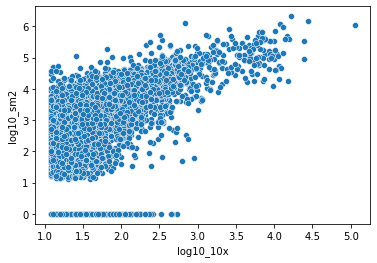

In [45]:
num_cell_min = 10
pbmc1_sm2_df_cytotox = pbmc1_sm2_df[pbmc1_sm2_df["CellType"].isin(["Cytotoxic T cell"])]
pbmc1_sm2_df_cytotox = pbmc1_sm2_df_cytotox.drop("CellType", axis=1)
pbmc1_sm2_df_cytotox = pbmc1_sm2_df_cytotox.transpose()
pbmc1_a_binary = np.where(pbmc1_sm2_df_cytotox>0,1,0)
pbmc1_sm2_df_cytotox = pbmc1_sm2_df_cytotox[pbmc1_a_binary.sum(axis=1) > num_cell_min]

pbmc2_10x_df_cytotox = pbmc2_10x_df[pbmc2_10x_df["CellType"].isin(["Cytotoxic T cell"])]
pbmc2_10x_df_cytotox = pbmc2_10x_df_cytotox.drop("CellType", axis=1)
pbmc2_10x_df_cytotox = pbmc2_10x_df_cytotox.transpose()
pbmc1_a_binary = np.where(pbmc2_10x_df_cytotox>0,1,0)
pbmc2_10x_df_cytotox = pbmc2_10x_df_cytotox[pbmc1_a_binary.sum(axis=1) > num_cell_min]

pbmc2_10x_df_cytotox = pbmc2_10x_df_cytotox.transpose()
pbmc1_sm2_df_cytotox = pbmc1_sm2_df_cytotox.transpose()

print(pbmc1_sm2_df_cytotox.shape)
print(pbmc2_10x_df_cytotox.shape)

d = {'log10_sm2': np.log10(sm2_sum+1), 'log10_10x':np.log10(x10_sum+1)}
plot_df = pd.DataFrame(data=d)
g = sns.scatterplot(data=plot_df,y='log10_sm2', x='log10_10x')




In [38]:

sm2_sum = pbmc1_sm2_df_cytotox.sum(axis=0)
x10_sum = pbmc2_10x_df_cytotox.sum(axis=0)
pbmc1_sm2_df_cytotox = pbmc1_sm2_df_cytotox.reindex(columns=pbmc2_10x_df_cytotox.columns, fill_value=0)

spr_err = pearsonr(sm2_sum.astype(float), x10_sum.astype(float))[0]
spr_err

ValueError: x and y must have the same length.

In [32]:
d = {'log10_sm2': np.log10(sm2_sum+1), 'log10_10x':np.log10(x10_sum+1)}
plot_df = pd.DataFrame(data=d)
plot_df

,log10_sm2,log10_10x
ENSG00000000003_TSPAN6,0.954243,1.447158
ENSG00000000419_DPM1,3.221936,1.886491
ENSG00000000457_SCYL3,2.173186,1.431364
ENSG00000000460_C1orf112,1.342423,0.903090
ENSG00000000938_FGR,4.117205,2.235528
...,...,...
ENSG00000283063_TRBV6-2,0.000000,0.778151
ENSG00000283073_RP11-834C11.15,0.000000,0.602060
ENSG00000283103_LLNLR-245B6.1,2.309630,1.698970
ENSG00000283117_CTD-2060L22.1,2.639486,0.698970


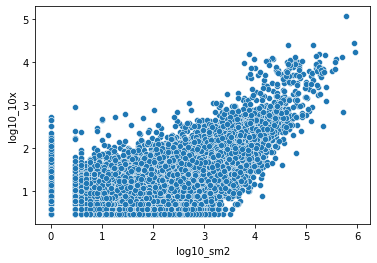

In [33]:

g = sns.scatterplot(data=plot_df,x='log10_sm2', y='log10_10x')


In [18]:
aug_data_path = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/"
res_data_path = "/beevol/home/davidson/checkouts/sc_bulk_ood/results/single_cell_data/diva_pbmc/"
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep1_sm2"

In [19]:

# read in the test / train data
X_train, Y_train, train_gene_df, _ = sc_preprocess.read_diva_files(aug_data_path, 0, train_id)
X_pbmc2, Y_pbmc2, pbmc2_gene_df, _ = sc_preprocess.read_diva_files(aug_data_path, 0, test_id)
gene_file = os.path.join(res_data_path, f"train-{train_id}-DIVA_features.pkl")
gene_path = Path(gene_file)
gene_df_train = pickle.load( open( gene_path, "rb" ) )


# now we need to ensure the genes are in the same order
X_pbmc2.columns = pbmc2_gene_df["gene_ids"]
X_pbmc2 = X_pbmc2.reindex(columns=gene_df_train["gene_ids"], fill_value=0)
X_pbmc2 = X_pbmc2[gene_df_train["gene_ids"]]

# we also need to ensure that the cell-types are in the same order
## need to add somthing to fill in missing columns
Y_pbmc2 = Y_pbmc2.reindex(columns=Y_train.columns, fill_value=0)
Y_pbmc2 = Y_pbmc2[Y_train.columns]


In [29]:
(X_pbmc2.sum(axis=0) == 0).value_counts()

False    789
True     211
dtype: int64

In [20]:
pbmc2_gene_df

,gene_ids
0,ENSG00000000003_TSPAN6
1,ENSG00000000005_TNMD
2,ENSG00000000419_DPM1
3,ENSG00000000457_SCYL3
4,ENSG00000000460_C1orf112
...,...
33688,ENSG00000283095_ABC11-4932300O16.1
33690,ENSG00000283103_LLNLR-245B6.1
33691,ENSG00000283117_CTD-2060L22.1
33692,ENSG00000283118_RP11-107E5.4


In [14]:
res_data_path = "/beevol/home/davidson/checkouts/sc_bulk_ood/results/single_cell_data/diva_pbmc/"
curr_exp_id = "pbmc_rep2_10xV2_sm2_cells"
feature_file = os.path.join(res_data_path, f"train-{curr_exp_id}-DIVA_features.pkl")

prop_train = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/pbmc_rep2_10xV2_sm2_cells_prop_0.pkl"
pseudo_test = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/pbmc_rep1_sm2_prop_0.pkl"
genes_test = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/pbmc_rep1_sm2_genes.pkl"
sig_test = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/pbmc_rep1_sm2_sig.pkl"


prop_train_df = pickle.load( open( prop_train, "rb" ) )
pseudo_test_df = pickle.load( open( pseudo_test, "rb" ) )
gene_test_df = pickle.load( open( genes_test, "rb" ) )
sig_test_df = pickle.load( open( sig_test, "rb" ) )
features_df = pickle.load( open( feature_file, "rb" ) )


In [1]:
# import out preprocessing code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess
import evaluation_experiments.pbmc.pbmc_generate_data as gen_data

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from argparse import ArgumentParser
from importlib import reload

import pickle
import gzip
from pathlib import Path

def get_genes(GSE_data_path, exp_id, min_num_cells):

    # these are pre-defined parameters that are inherent
    # to each experiment
    pbmc1_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc1', 
                        "num_cells":[253],
                        "file_id":'pbmc_rep1_sm2'})

    pbmc2_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[273],
                        "file_id":'pbmc_rep2_sm2'})

    pbmc1_10x_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a'})

    pbmc1_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a_sm2_cells'})

    pbmc2_10x_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2'})

    pbmc2_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2_sm2_cells'})

    sm2_cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                    'CD16+ monocyte', 'B cell',
                    'CD4+ T cell', 'Megakaryocyte']

    #####################
    ### set the study ###
    #####################
    cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
    count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
    gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")
    meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
    meta_tsne_file = os.path.join(GSE_data_path, "GSE132044_meta.txt")


    if exp_id == "pbmc_rep1_sm2" :
        curr_study = pbmc1_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep2_sm2" :
        curr_study = pbmc2_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep1_10xV2a":
        curr_study = pbmc1_10x_param
    elif exp_id == "pbmc_rep1_10xV2a_sm2_cells":
        curr_study = pbmc1_10x_sm2_cells_param
    elif exp_id == "pbmc_rep2_10xV2":
        curr_study = pbmc2_10x_param
    elif exp_id == "pbmc_rep2_10xV2_sm2_cells":
        curr_study = pbmc2_10x_sm2_cells_param
    else:
        assert False, "Unrecognized experiment ID"


    # set the study specific parameters
    num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])
    method_keep = curr_study["Method"].tolist()
    experiment_keep = curr_study["Experiment"].tolist()

    # read in the data
    cell_info, count_matr, gene_info, meta_info = gen_data.read_gse_input(cell_file, 
                                                                count_file, 
                                                                gene_file, 
                                                                meta_file, 
                                                                meta_tsne_file)

    # format the data
    pbmc1_a_dense = gen_data.format_cell_reads_info(meta_info, cell_info, count_matr, 
                                                    num_cells_expected, method_keep, 
                                                    experiment_keep)

    # get the gene names that pass
    pbmc1_a_expr, gene_pass = gen_data.filter_by_expr(pbmc1_a_dense, -1, gene_info)

    # get cell type info
    pbmc1_a_df, _ = gen_data.join_metadata(cell_info, meta_info, pbmc1_a_expr, gene_pass)

    # filter to sm2 cell types if needed
    if exp_id == "pbmc_rep1_10xV2a_sm2_cells" or exp_id == "pbmc_rep2_10xV2_sm2_cells":
        pbmc1_a_df = pbmc1_a_df[pbmc1_a_df['CellType'].isin(sm2_cell_types)]


    # get the gene names that pass
    pbmc1_a_df = pbmc1_a_df.drop("CellType", axis=1)
    pbmc1_a_df = pbmc1_a_df.transpose()
    pbmc1_a_binary = np.where(pbmc1_a_df>0,1,0)
    pbmc1_a_df = pbmc1_a_df[pbmc1_a_binary.sum(axis=1) > min_num_cells]


    return pbmc1_a_df.index


In [12]:
GSE_data_path = '/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/GSE132044/'
aug_data_path = '/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/'


min_num_cells = 10
all_ids = ['pbmc_rep1_sm2', 'pbmc_rep2_sm2', 'pbmc_rep1_10xV2a_sm2_cells', 'pbmc_rep2_10xV2_sm2_cells']

inter_genes = []
for exp_id in all_ids:
    index_res = get_genes(GSE_data_path, exp_id, min_num_cells)
    index_res = index_res.tolist()
    inter_genes.append(index_res)

from functools import reduce
inter_genes = reduce(np.intersect1d, inter_genes)

Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22654, 253)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (23262, 273)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (20430, 3222)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22757, 3362)


In [36]:
idx_range = range(0, 12)
train_file_name = "pbmc_rep2_10xV2_sm2_cells"
X_train, Y_train, gene_df = sc_preprocess.read_all_diva_files(aug_data_path, idx_range, train_file_name)


file_id = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/intersection_genes.pkl"
common_genes = pickle.load(open( file_id, "rb" ))


In [47]:
GSE_data_path = '/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/GSE132044/'
aug_data_path = '/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/'
from sklearn.preprocessing import scale

# import out preprocessing code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess
import evaluation_experiments.pbmc.pbmc_generate_data as gen_data

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from argparse import ArgumentParser
from importlib import reload
from functools import reduce

import pickle
import gzip
from pathlib import Path

def get_genes(GSE_data_path, exp_id, min_num_cells):

    # these are pre-defined parameters that are inherent
    # to each experiment
    pbmc1_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc1', 
                        "num_cells":[253],
                        "file_id":'pbmc_rep1_sm2'})

    pbmc2_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[273],
                        "file_id":'pbmc_rep2_sm2'})

    pbmc1_10x_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a'})

    pbmc1_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a_sm2_cells'})

    pbmc2_10x_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2'})

    pbmc2_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2_sm2_cells'})

    sm2_cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                    'CD16+ monocyte', 'B cell',
                    'CD4+ T cell', 'Megakaryocyte']

    #####################
    ### set the study ###
    #####################
    cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
    count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
    gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")
    meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
    meta_tsne_file = os.path.join(GSE_data_path, "GSE132044_meta.txt")


    if exp_id == "pbmc_rep1_sm2" :
        curr_study = pbmc1_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep2_sm2" :
        curr_study = pbmc2_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep1_10xV2a":
        curr_study = pbmc1_10x_param
    elif exp_id == "pbmc_rep1_10xV2a_sm2_cells":
        curr_study = pbmc1_10x_sm2_cells_param
    elif exp_id == "pbmc_rep2_10xV2":
        curr_study = pbmc2_10x_param
    elif exp_id == "pbmc_rep2_10xV2_sm2_cells":
        curr_study = pbmc2_10x_sm2_cells_param
    else:
        assert False, "Unrecognized experiment ID"


    # set the study specific parameters
    num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])
    method_keep = curr_study["Method"].tolist()
    experiment_keep = curr_study["Experiment"].tolist()

    # read in the data
    cell_info, count_matr, gene_info, meta_info = gen_data.read_gse_input(cell_file, 
                                                                count_file, 
                                                                gene_file, 
                                                                meta_file, 
                                                                meta_tsne_file)

    # format the data
    pbmc1_a_dense = gen_data.format_cell_reads_info(meta_info, cell_info, count_matr, 
                                                    num_cells_expected, method_keep, 
                                                    experiment_keep)

    # get the gene names that pass
    pbmc1_a_expr, gene_pass = gen_data.filter_by_expr(pbmc1_a_dense, -1, gene_info)

    # get cell type info
    pbmc1_a_df, _ = gen_data.join_metadata(cell_info, meta_info, pbmc1_a_expr, gene_pass)

    # filter to sm2 cell types if needed
    if exp_id == "pbmc_rep1_10xV2a_sm2_cells" or exp_id == "pbmc_rep2_10xV2_sm2_cells":
        pbmc1_a_df = pbmc1_a_df[pbmc1_a_df['CellType'].isin(sm2_cell_types)]


    # get the gene names that pass
    pbmc1_a_df = pbmc1_a_df.drop("CellType", axis=1)
    pbmc1_a_df = pbmc1_a_df.transpose()
    pbmc1_a_binary = np.where(pbmc1_a_df>0,1,0)
    pbmc1_a_df = pbmc1_a_df[pbmc1_a_binary.sum(axis=1) > min_num_cells]


    return pbmc1_a_df.index

def get_variable_genes(aug_data_path, inter_genes, num_genes):

    # only get genes that are available in both testing and training
    common_genes = inter_genes


    X_train, Y_train, gene_df_train, _ = sc_preprocess.read_diva_files(aug_data_path, 0, exp_id)
    X_train = X_train[common_genes]
    X_train = X_train.to_numpy()
    Y_train = Y_train.to_numpy()

    gene_df_train = gene_df_train.loc[gene_df_train['gene_ids'].isin(common_genes)]


    ## get the top variable genes
    X_colmean = X_train.mean(axis=0)
    X_colvar = X_train.var(axis=0)
    X_CoV = np.array(np.divide(X_colvar, X_colmean))
    idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
    X_train = X_train[:,idx_top]
    gene_df_train = gene_df_train.iloc[idx_top]

    return(gene_df_train)



In [53]:

min_num_cells = 10
all_ids = ['pbmc_rep1_sm2', 'pbmc_rep2_sm2', 'pbmc_rep1_10xV2a_sm2_cells', 'pbmc_rep2_10xV2_sm2_cells']

inter_genes = []
for exp_id in all_ids:
    index_res = get_genes(GSE_data_path, exp_id, min_num_cells)
    index_res = index_res.tolist()
    inter_genes.append(index_res)

inter_genes = reduce(np.intersect1d, inter_genes)

var_genes = []
for exp_id in all_ids:
    index_res = get_variable_genes(aug_data_path, inter_genes, num_genes=3000)
    index_res = index_res['gene_ids']
    var_genes.append(index_res)

var_genes = reduce(np.intersect1d, var_genes)


# write out the gene ids



Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22654, 253)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (23262, 273)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (20430, 3222)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22757, 3362)


In [54]:
var_genes.shape


(1492,)

In [40]:
print(gene_df_sm1.shape)

## get the top variable genes
X_colmean = X_sm1.mean(axis=0)
X_colvar = X_sm1.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
X_sm1 = X_sm1[:,idx_top]
gene_df_sm1 = gene_df_sm1.iloc[idx_top]

## normalize within sample
X_sm1 = scale(X_sm1, axis=1)
            


(9893, 1)


In [45]:
from functools import reduce

inter_genes = np.intersect1d(gene_df_10x, gene_df_sm2)
print(inter_genes.shape)

inter_genes = np.intersect1d(gene_df_10x, gene_df_sm1)
print(inter_genes.shape)

inter_genes = np.intersect1d(gene_df_sm2, gene_df_sm1)
print(inter_genes.shape)

inter_genes = reduce(np.intersect1d, [gene_df_sm2, gene_df_sm1, gene_df_10x])
print(inter_genes.shape)
gene_df_sm1['gene_ids']

(3560,)
(3563,)
(3986,)
(3125,)


301         ENSG00000011485_PPP5C
9764          ENSG00000155368_DBI
12419       ENSG00000169371_SNUPN
23915       ENSG00000242802_AP5Z1
4824       ENSG00000118960_HS1BP3
                   ...           
33508       ENSG00000281649_EBLN3
5             ENSG00000000938_FGR
33625       ENSG00000282851_BISPR
4        ENSG00000000460_C1orf112
8482        ENSG00000144455_SUMF1
Name: gene_ids, Length: 5000, dtype: object